In [1]:
import os
import sys
import inspect 
import time
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import weierstrass as weier
from runs.runs_entropy import RRLoader,RRLoaderShuffled, Signal, Runs
import seaborn as sns
import statsmodels.api as sm

In [2]:
def resource_files():
    resource_dir = "tests/resources/rr"
    file_paths = []

    for root, dirs, files in os.walk(resource_dir):
        for file in files:
            file_paths.append(os.path.join(root, file))

    return file_paths

In [4]:
def get_entropy_df(signal_generator, num_samples, len_sample=None, resources=None, **kwargs):
    har, hdr, hno = [], [], []
    
    for idx in range(num_samples):
        if isinstance(signal_generator, type):  # if its class and not function then we need specific RRloader from core.runs.runs_entropy
            rr, annotations = signal_generator().load(resources[idx], 0, 1)
            signal = Signal(rr, annotations)
        else:  # It's a function
            signal_data = signal_generator(len_sample, **kwargs)
            annotations = np.zeros(len(signal_data))
            signal = Signal(signal_data, annotations=annotations)
        
        runs = Runs(signal)
        har.append(runs.HAR)
        hdr.append(runs.HDR)
        hno.append(runs.HNO)
    
    return pd.DataFrame(np.array([har, hdr, hno]).T, columns=['HAR', 'HDR', 'HNO'])

def get_entropy_from_csv(filename):
    har,hdr,hno = [],[],[]
    r_weier = pd.read_csv(filename)
    for col in r_weier.columns:
        signal_data = r_weier[col]
        annotations = np.zeros(len(signal_data))
        signal = Signal(signal_data, annotations=annotations)

        runs = Runs(signal)
        har.append(runs.HAR)
        hdr.append(runs.HDR)
        hno.append(runs.HNO)
    return pd.DataFrame(np.array([har, hdr, hno]).T, columns=['HAR', 'HDR', 'HNO'])

# Helper functions for signal generation
def weierstrass_jp_noisy(len_sample):
    return weier.asymmetric_weierstrass_jp(len_sample)

def weierstrass_jp(len_sample):
    D = np.random.uniform(1.2, 1.8)
    return weier.weierstrass(len_sample, D)

def weierstrass_sawtooth(len_sample, a=0.5, b=3):
    return weier.asymmetric_weierstrass_sawtooth(a, b, len_sample)

def weierstrass_normal(len_sample):
    D = np.random.uniform(1.2, 1.8)
    return weier.weierstrass(len_sample,D)

def ar_function(len_sample, phi=0.1, sigma=0.1, scale=3):
    return weier.autoregressive_function(len_sample, phi, sigma, scale)

def random_walk_with_bias(n_steps, p_forward=0.8):
    return weier.biased_random_walk(n_steps, p_forward)

def asymmetric_ar_function_jp(len_sample, phi=0.1, sigma=0.1, scale=3):
    return weier.asymmetric_autoregressive_jp(len_sample, phi, sigma, scale)

def normal_distribution(len_sample, mean=0, sigma=0.1, scale=3):
    std_dev = sigma * scale
    return np.random.normal(loc=mean, scale=std_dev, size=len_sample)

def chisquare_distribution(num_samples, df=2):
    signal = np.random.chisquare(df=df, size=num_samples)
    return signal

def perform_binomial_tests_and_plot(dfs):
    for i, df in enumerate(dfs):
        
        # Perform binomial test
        har_values = df[0]['HAR'] 
        #har_count = har_values.sum()
        hdr_values = df[0]['HDR']
        #hdr_count = hdr_values.sum()
        #total_count = har_count + hdr_count
        har_bigger = np.count_nonzero(har_values > hdr_values) #sum([1 if har > hdr else 0 for har,hdr in zip(har_values,hdr_values)])
        print(f"HAR > HDR :{har_bigger}")
        p_value = stats.binom_test(har_bigger, n=NUM_SAMPLES, p=0.5)
        
        print(f"Binomial test p-value: {p_value:.4f}")
        
        #w_statistic, p_value_wilcoxon = stats.ttest_rel(har_values, hdr_values)
        #print(f"Wilcoxon test p-values: {p_value_wilcoxon:.4f}")
        
        # Plot boxplot
        plt.figure(figsize=(8, 6))
        df[0].boxplot(column=['HAR', 'HDR'])
        plt.title(f"Boxplot of HAR and HDR (DataFrame {df[1]})")
        plt.xlabel("")
        plt.ylabel("")
        plt.tight_layout()
        plt.show()

In [5]:
resources = resource_files()

import warnings
warnings.filterwarnings("ignore") # hide HNO warnings

# Create a list of tuples containing (dataframe, label, function/class, kwargs)
NUM_SAMPLES = 50
dataframes = [
    (get_entropy_from_csv("r_weierstrass_results.csv"),"weierstrass from R code"),
    (get_entropy_from_csv("r_weierstrass_noisy_results.csv"),"noisy weierstrass from R code"),
    (get_entropy_df(weierstrass_jp, num_samples=NUM_SAMPLES, len_sample=1000), "Weierstrass ", weierstrass_jp, {}),
    (get_entropy_df(weierstrass_jp_noisy, num_samples=NUM_SAMPLES, len_sample=1000), "Asymmetric noise Weierstrass", weierstrass_jp, {}),
    (get_entropy_df(random_walk_with_bias, num_samples=NUM_SAMPLES, len_sample=10000), "Random walk with bies", random_walk_with_bias, {}),
    (get_entropy_df(normal_distribution, num_samples=NUM_SAMPLES, len_sample=10000), "Normal Distribution", normal_distribution, {}),
    (get_entropy_df(chisquare_distribution, num_samples=NUM_SAMPLES, len_sample=10000), "Chi-square Distribution", chisquare_distribution, {})
]


HAR > HDR :50
Binomial test p-value: 0.0000


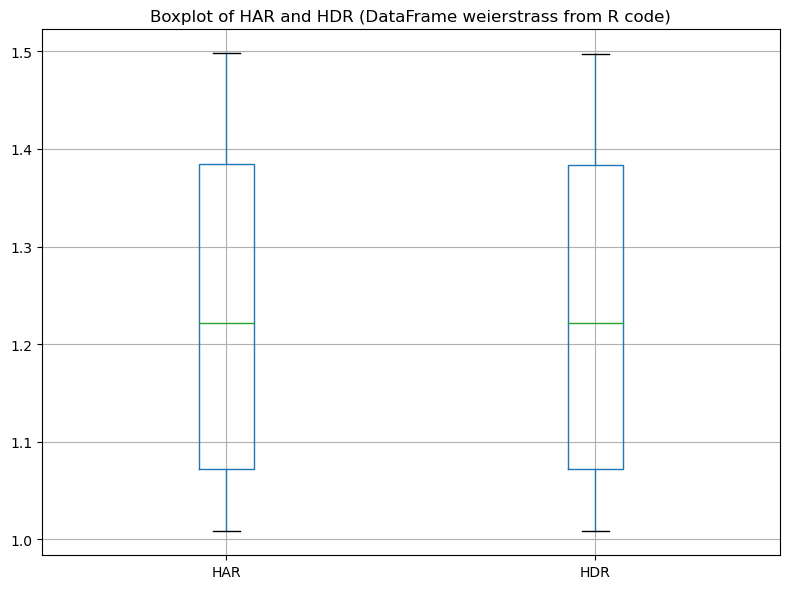

HAR > HDR :34
Binomial test p-value: 0.0153


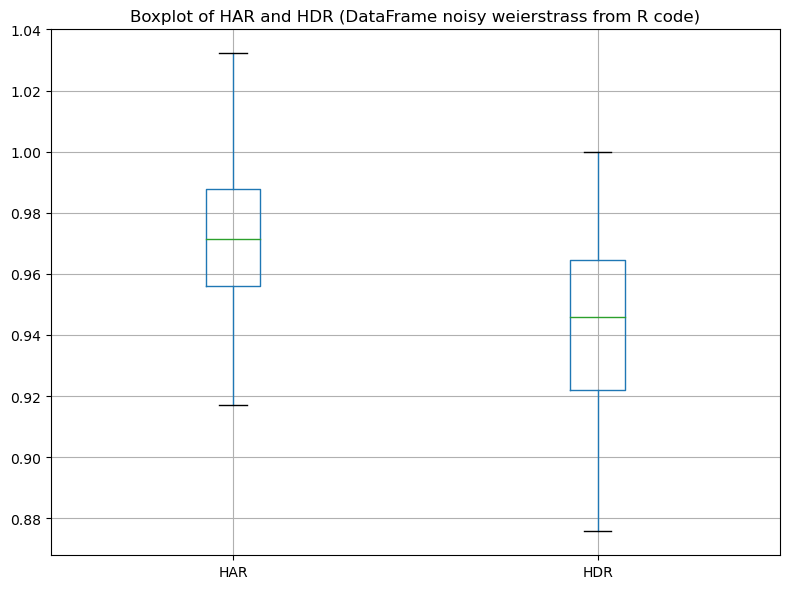

HAR > HDR :0
Binomial test p-value: 0.0000


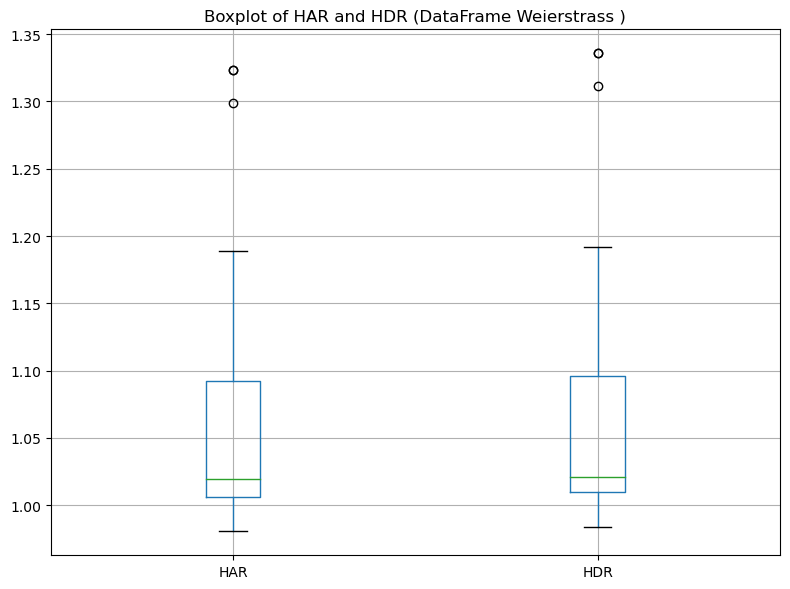

HAR > HDR :46
Binomial test p-value: 0.0000


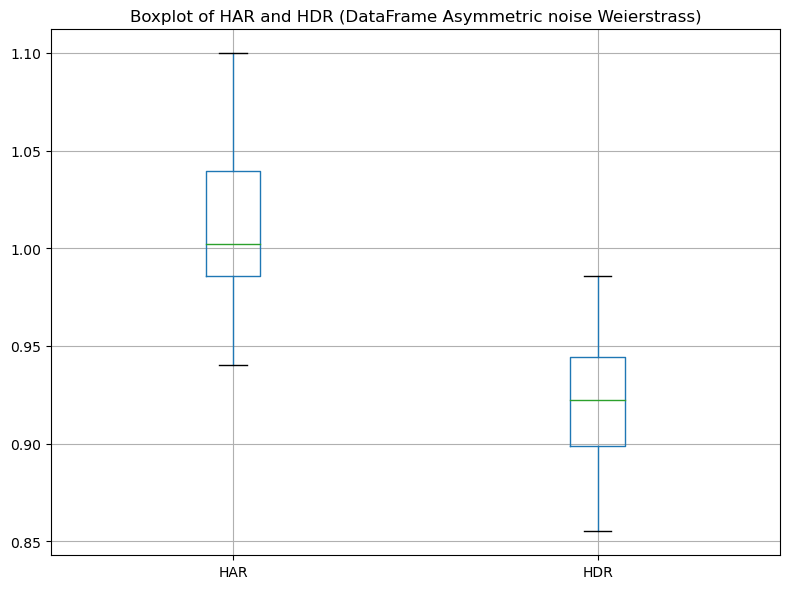

HAR > HDR :50
Binomial test p-value: 0.0000


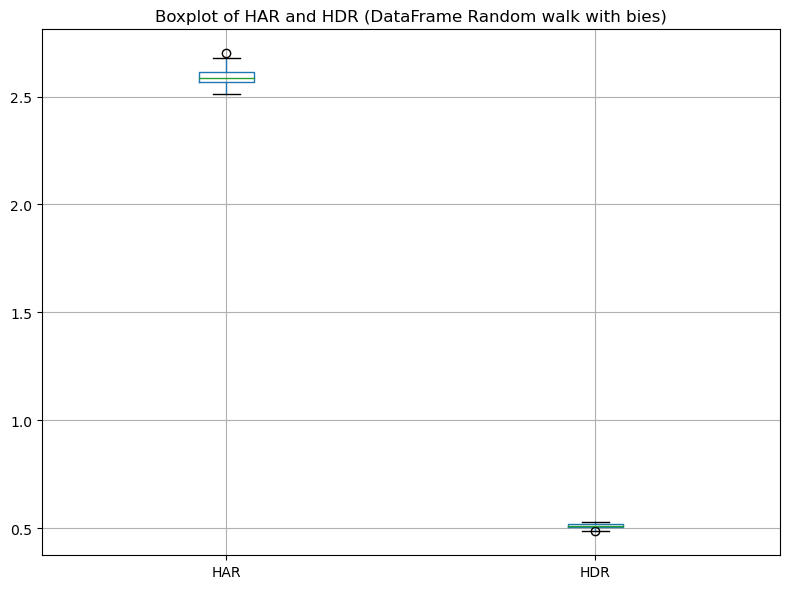

HAR > HDR :22
Binomial test p-value: 0.4799


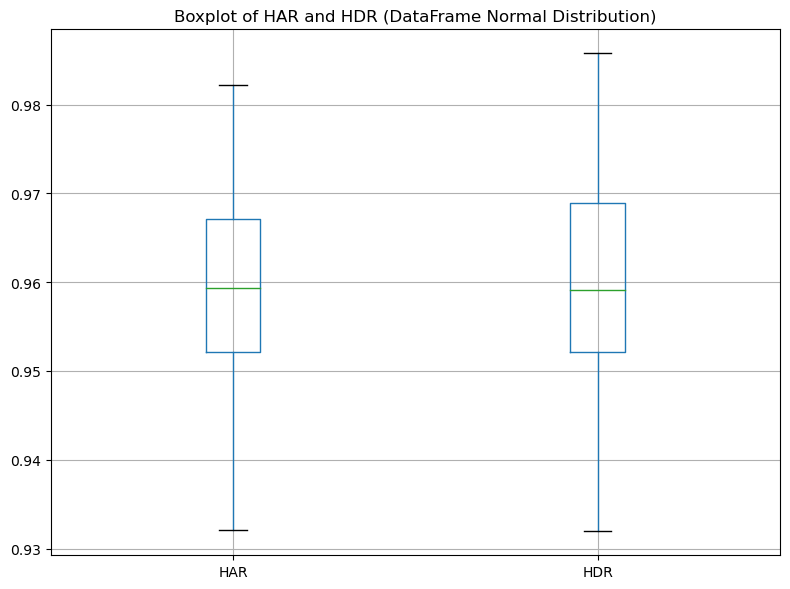

HAR > HDR :22
Binomial test p-value: 0.4799


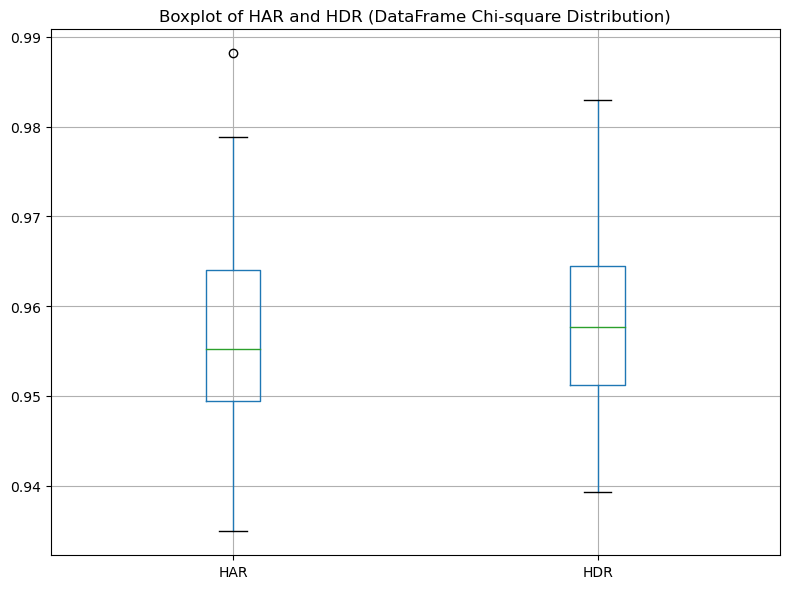

In [6]:
perform_binomial_tests_and_plot(dataframes)